In [1]:
import pandas as pd
import csv, sys, time
import numpy as np
from scipy.optimize import curve_fit
import scipy.stats as sp
import matplotlib.pyplot as plt
import wordcloud
import seaborn as sns
import matplotlib.cm as cm
import string
%matplotlib inline

# Fig 1: Publication and citation totals over time ('clouds' AND 'climate')
Show the total count per year of publications discussing 'clouds' and 'climate' in environmental and planetary sciences. First read in all data via a csv generated through a Scopus search. Then group these citations by years and count the total publications and *unique* sources per year and perform an exponential fit to each. The first cell below was an erroneous attempt when I did a search on 'clouds' OR 'climate'. I converted it to a raw cell via Esc+r but it can be converted back to active by Esc+y.

The other panels look at the citation number stratified by decade and US funding + student numbers over time. It would be nice to find data from outside the US.

In [2]:
# Reads in results for the search <clouds AND climate>. 11343 entries.
scopus = pd.read_csv('scopus-clouds-and-climate.csv')

# Count the number of titles per year.
title_per_yr = scopus.groupby('Year').count()[['Title']]
print('How many publications per year on average in the following decades?')
print('1980-1990 mean: ' + str(title_per_yr.loc[1980:1990].mean()))
print('1990-2000 mean: ' + str(title_per_yr.loc[1990:2000].mean()))
print('2000-2010 mean: ' + str(title_per_yr.loc[2000:2010].mean()))
print('2010-2020 mean: ' + str(title_per_yr.loc[2010:2020].mean()))

How many publications per year on average in the following decades?
1980-1990 mean: Title    27.090909
dtype: float64
1990-2000 mean: Title    114.454545
dtype: float64
2000-2010 mean: Title    293.272727
dtype: float64
2010-2020 mean: Title    659.545455
dtype: float64


In [3]:
# Count the number of unique sources per year.
sources_per_yr = scopus.groupby('Year')['Source title'].nunique()
sources_per_yr.rename('Unique source number',inplace=True)
print('How many unique sources were there in the 1980s / 1990s / 2000s / 2010s?')
sources1 = scopus[(scopus['Year'] >= 1980) & (scopus['Year'] < 1990)]['Source title']
sources2 = scopus[(scopus['Year'] >= 1990) & (scopus['Year'] < 2000)]['Source title']
sources3 = scopus[(scopus['Year'] >= 2000) & (scopus['Year'] < 2010)]['Source title']
sources4 = scopus[(scopus['Year'] >= 2010) & (scopus['Year'] < 2020)]['Source title']
print(sources1.nunique(),sources2.nunique(),sources3.nunique(),sources4.nunique())
print('Which three sources were the most common in each decade?')
print(sources1.value_counts()[:6])
print(sources2.value_counts()[:5])
print(sources3.value_counts()[:5])
print(sources4.value_counts()[:5])

How many unique sources were there in the 1980s / 1990s / 2000s / 2010s?
114 193 277 496
Which three sources were the most common in each decade?
Journal of the Atmospheric Sciences                      25
[No title available]                                     20
Advances in Space Research                               15
Journal of Geophysical Research                          14
Quarterly Journal of the Royal Meteorological Society     7
Atmospheric Research                                      7
Name: Source title, dtype: int64
Journal of Climate                             115
Journal of Geophysical Research Atmospheres     90
Journal of Geophysical Research                 57
Geophysical Research Letters                    56
Journal of the Atmospheric Sciences             45
Name: Source title, dtype: int64
Journal of Geophysical Research Atmospheres    344
Journal of Climate                             335
Geophysical Research Letters                   285
Journal of the Atmos

In [4]:
# Logarithmic fit for these search results. 
def exponential(x, a, b):
    return a*2**(b*x)

# Find indices corresponding to 1970 and 2019.
ii = np.argwhere(title_per_yr.index == 1970)[0][0]
jj = np.argwhere(title_per_yr.index == 2020)[0][0]
yr = title_per_yr.index[ii:jj]   # pandas.core.indexes.numeric.Int64Index
pars, _ = curve_fit(f=exponential, xdata=yr-1970, ydata=title_per_yr['Title'].iloc[ii:jj])
pars2, _ = curve_fit(f=exponential, xdata=yr-1970, ydata=sources_per_yr.iloc[ii:jj])

# Linear fit for these search results.
def lin(x, a, b):
    return a*x + b

# Non-NaN propagating standard error
def sem_nonan(arr):
    return sp.sem(arr,nan_policy='omit')

# Calculate the average page count per years, filtering for Document Type = Article.
scopus['Page end'] = pd.to_numeric(scopus['Page end'],errors='coerce') 
scopus['Page start'] = pd.to_numeric(scopus['Page start'],errors='coerce')
scopus['Page count'] = scopus['Page end'] - scopus['Page start']
a = scopus.groupby('Year')['Page count'].mean()
b = scopus.groupby('Year')['Page count'].agg(sem_nonan)
c = scopus.groupby('Year')['Page count'].agg(np.std)
# This expression omits the outlier in 2011.
avg_page_count = a[a.between(a.quantile(0.05),a.quantile(0.95))]
sterr_page_count = b[a.between(a.quantile(0.05),a.quantile(0.95))]
stdev_page_count = c[a.between(a.quantile(0.05),a.quantile(0.95))]

# Find the indices corresponding to 1970 and 2019.
ii = np.argwhere(avg_page_count.index == 1970)[0][0]
jj = np.argwhere(avg_page_count.index == 2020)[0][0]
yr2 = avg_page_count.index[ii:jj]   # pandas.core.indexes.numeric.Int64Index
pars3, _ = curve_fit(f=lin, xdata=yr2-1970, ydata=avg_page_count.iloc[ii:jj])

/pf/b/b380873/.local/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/pf/b/b380873/.local/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [5]:
%%capture
fs = 14
fig1, ax = plt.subplots(nrows=2,ncols=3,figsize=(19,10))
ax[0,0].scatter(title_per_yr.index.values,title_per_yr['Title'])
ax[0,0].plot(yr,pars[0]*2**(pars[1]*(yr-1970)),color='k',linewidth=1.2)
ax[0,0].set_xlabel('Year',fontsize=fs)
ax[0,0].set_ylabel('Publications per year',fontsize=fs)
ax[0,0].set_xlim([1970,2019])
ax[0,0].tick_params(axis='both',labelsize=fs)
ax[0,0].text(0.05,0.92,'(a)',weight='bold',fontsize=fs+4,transform=ax[0,0].transAxes)
growthrate = 2**(pars[1])
ax[0,0].text(0.05,0.8,r'$N(x)$ = $N_0\cdot$%.4f$^{(x-1970)}$'%(growthrate),fontsize=fs+2,transform=ax[0,0].transAxes)

ax[0,1].scatter(sources_per_yr.index.values,sources_per_yr)
ax[0,1].plot(yr,pars2[0]*2**(pars2[1]*(yr-1970)),color='k',linewidth=1.2)
ax[0,1].set_xlabel('Year',fontsize=fs)
ax[0,1].set_ylabel('Unique sources per year',fontsize=fs)
ax[0,1].set_xlim([1970,2019])
ax[0,1].tick_params(axis='both',labelsize=fs)
ax[0,1].text(0.05,0.92,'(b)',weight='bold',fontsize=fs+4,transform=ax[0,1].transAxes)
growthrate = 2**(pars2[1])
ax[0,1].text(0.05,0.8,r'$s(x)$ = $s_0\cdot$%.4f$^{(x-1970)}$'%(growthrate),fontsize=fs+2,transform=ax[0,1].transAxes)

ax[1,2].errorbar(avg_page_count.index.values,avg_page_count,yerr=sterr_page_count,
              marker='o',ecolor='r',ls='None')
ax[1,2].plot(yr2,pars3[0]*(yr2-1970) + pars3[1],color='k',linewidth=1.2)
ax[1,2].set_xlabel('Year',fontsize=fs)
ax[1,2].set_ylabel('Pages per publication',fontsize=fs,labelpad=-3)
ax[1,2].set_xlim([1970,2019])
ax[1,2].set_ylim([0,30])
ax[1,2].tick_params(axis='both',labelsize=fs)
ax[1,2].text(0.05,0.92,'(f)',weight='bold',fontsize=fs+4,transform=ax[1,2].transAxes)
ax[1,2].text(0.25,0.1,r'$p(x)$ = $p_0$ + %.3f(x-1970)'%(pars3[0]),fontsize=fs,transform=ax[1,2].transAxes)

In [6]:
# Doctorate degrees and funding dollars awarded in geosciences in the US.
us_deg = pd.read_csv('US-doctorates-by-field.csv')
us_yr = np.array([int(i) for i in us_deg.iloc[5].index.values[1:]])
us_deg = np.array([int(i.replace(",","")) for i in us_deg.iloc[5][1:]])

us_funding = pd.read_csv('US-research-funding-by-field.csv')
us_yr2 = np.array([int(i) for i in us_funding.iloc[12].index.values[1:]])
us_funding = np.array([int(i.replace(",","")) for i in us_funding.iloc[12][1:]])

#print('How many funding dollars per student in 1999?')
#print(us_yr[19],us_yr2[2],us_funding[19]/us_deg[19])
#print(us_yr2[19],us_funding[19])

yr = [1980,1990,2000,2010]
print('How many article had less than 10 citations in each decade?')
for y in yr:
    cited = scopus['Cited by'].loc[scopus['Year'].between(y,y+9,inclusive=True)]
    print(len(cited[cited < 10])/len(cited)*100)

How many article had less than 10 citations in each decade?
31.07569721115538
19.30835734870317
15.40983606557377
39.67237527922561


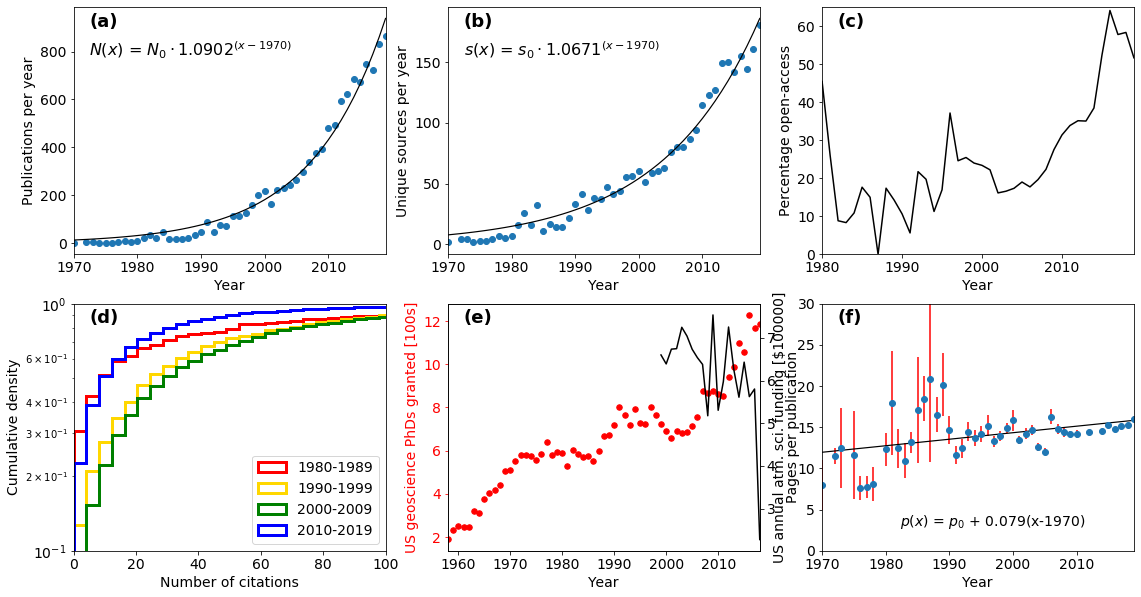

<Figure size 432x288 with 0 Axes>

In [7]:
# Bins and decade 'dividers' for the histogram of citations. No kernel density estimate below (kde=False).
xx = np.linspace(0,200,50)
yr = [1980,1990,2000,2010]
farbe = ['red','gold','green','blue']
#fig2, ax = plt.subplots(nrows=1,ncols=3,figsize=(16,5))
for i,y in enumerate(yr):
    sns.distplot(scopus['Cited by'].loc[scopus['Year'].between(y,y+9,inclusive=True)].dropna(),
                 bins=xx,kde=False,ax=ax[1,0],hist_kws={"histtype": "step", "linewidth": 3,"alpha": 1, 
                 "color": farbe[i],"cumulative":True},label=str(y)+'-'+str(y+9),norm_hist=True)
ax[1,0].legend(fontsize=fs,loc='lower right')
ax[1,0].set_yscale('log')
ax[1,0].set_ylim([0.1,1])
ax[1,0].set_xlim([0,100])
ax[1,0].tick_params('both',labelsize=fs)
ax[1,0].set_ylabel('Cumulative density',fontsize=fs)
ax[1,0].set_xlabel('Number of citations',fontsize=fs)
ax[1,0].text(0.05,0.92,'(d)',weight='bold',fontsize=fs+4,transform=ax[1,0].transAxes)

# We start from 1980 for Open Access designation because 1970-1979 is almost empty.
perc_open_access = np.zeros((2020-1980))
for i in np.arange(1980,2020):
    yr = len(scopus[scopus['Year'] == i])
    if yr != 0:
        sub = scopus[(scopus['Year']==i) & (scopus['Access Type']=='Open Access')]
        perc_open_access[i-1980] = float(len(sub)) / float(yr) * 100.
    else:
        perc_open_access[i-1980] = 0

ax[0,2].plot(np.arange(1980,2020),perc_open_access,lw=1.5,color='k')
ax[0,2].tick_params('both',labelsize=fs)
ax[0,2].set_ylim([0,65])
ax[0,2].set_xlim([1980,2019])
ax[0,2].set_ylabel('Percentage open-access',fontsize=fs)
ax[0,2].set_xlabel('Year',fontsize=fs)
ax[0,2].text(0.05,0.92,'(c)',weight='bold',fontsize=fs+4,transform=ax[0,2].transAxes)

ax[1,1].scatter(us_yr,us_deg/100.,c='r',s=30)
ax[1,1].set_xlim([1958,2018])
ax[1,1].tick_params(axis='both',labelsize=fs)
ax[1,1].tick_params(axis='y',colors='red')
ax2 = ax[1,1].twinx()
ax2.plot(us_yr2,us_funding/100000.,'k')
ax2.tick_params('both',labelsize=fs)
ax[1,1].set_xlabel('Year',fontsize=fs)
ax[1,1].set_ylabel('US geoscience PhDs granted [100s]',color='r',fontsize=fs)
ax2.set_ylabel('US annual atm. sci. funding [$100000]',fontsize=fs,labelpad=-3)
ax[1,1].text(0.05,0.92,'(e)',weight='bold',fontsize=fs+4,transform=ax[1,1].transAxes)

plt.tight_layout(pad=0.2)
fig1.savefig('publications-citations.pdf',bbox_inches='tight')
fig1

# Fig 2: Publication totals per theme over time

Read in the per-theme csv files and generate word clouds of their titles. The stopwords option within the WordCloud command omits certain 'junk' / obvious words like 'using'. The last cell here is raw because it was an unneccessary attempt to omit these junk words manually... oops.

In [8]:
# Read in the dataframes concerning circulation, radiation, precipitation.
circ = pd.read_csv('clouds-climate-circulation.csv')
rad = pd.read_csv('clouds-climate-radiation.csv')
prec = pd.read_csv('clouds-climate-precipitation.csv')

# Count the number of titles per year as above for all ctrations.
circ_per_yr = circ.groupby('Year').count()[['Title']]
rad_per_yr = rad.groupby('Year').count()[['Title']]
prec_per_yr = prec.groupby('Year').count()[['Title']]

# Remove the subscript junk from the titles.
title1 = np.zeros((circ['Title'].values.shape),dtype=object)
for j,t in enumerate(circ['Title'].values):
    title1[j] = t.replace('<inf>','').replace('</inf>','')

# Write the titles to a text file.
title_write = False
if title_write == True:
    np.savetxt('cloud_circulation_title.txt',title1,fmt='%s')
    np.savetxt('cloud_radiation_title.txt',rad['Title'].values,fmt='%s')
    np.savetxt('cloud_precipitation_title.txt',prec['Title'].values,fmt='%s')

7.956111247525203
4.7344693478654225
2.6761763776179612


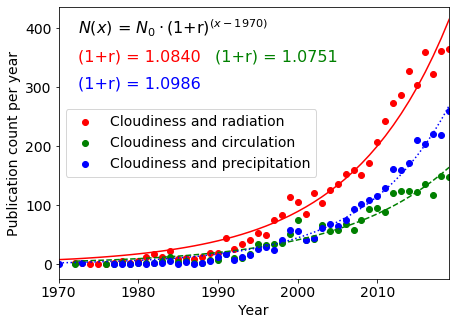

In [9]:
# Plot the time series per theme over time and then perform the exponential fit.
fs = 14
fig2, ax = plt.subplots(nrows=1,ncols=1,figsize=(7,5))
ax.scatter(rad_per_yr.index.values,rad_per_yr['Title'],color='r',label='Cloudiness and radiation')
ax.scatter(circ_per_yr.index.values,circ_per_yr['Title'],color='g',label='Cloudiness and circulation')
ax.scatter(prec_per_yr.index.values,prec_per_yr['Title'],color='b',label='Cloudiness and precipitation')

ii = np.argmin(np.abs(rad_per_yr.index - 1970))
jj = np.argwhere(rad_per_yr.index == 2020)[0][0]
yr = rad_per_yr.index[ii:jj]   # pandas.core.indexes.numeric.Int64Index
pars, _ = curve_fit(f=exponential, xdata=yr-1970, ydata=rad_per_yr['Title'][ii:jj])
ax.plot(yr,pars[0]*2**(pars[1]*(yr-1970)),color='r',linewidth=1.5)
ax.text(0.05,0.9,r'$N(x)$ = $N_0\cdot$(1+r)$^{(x-1970)}$',fontsize=fs+2,color='k',
        transform=ax.transAxes)
growthrate = 2**(pars[1])
ax.text(0.05,0.8,'(1+r) = ' + '{:01.4f}'.format(growthrate),fontsize=fs+2,color='r',
        transform=ax.transAxes)
print(pars[0])

ii = np.argmin(np.abs(circ_per_yr.index - 1970))
jj = np.argwhere(circ_per_yr.index == 2020)[0][0]
yr = circ_per_yr.index[ii:jj]
pars, _ = curve_fit(f=exponential, xdata=yr-1970, ydata=circ_per_yr['Title'][ii:jj])
ax.plot(yr,pars[0]*2**(pars[1]*(yr-1970)),color='g',linestyle='--',linewidth=1.5)
growthrate = 2**(pars[1])
ax.text(0.4,0.8,'(1+r) = ' + '{:01.4f}'.format(growthrate),fontsize=fs+2,color='g',
        transform=ax.transAxes)
print(pars[0])

ii = np.argmin(np.abs(prec_per_yr.index - 1970))
jj = np.argwhere(prec_per_yr.index == 2020)[0][0]
yr = prec_per_yr.index[ii:jj]
pars, _ = curve_fit(f=exponential, xdata=yr-1970, ydata=prec_per_yr['Title'][ii:jj])
ax.plot(yr,pars[0]*2**(pars[1]*(yr-1970)),color='b',linestyle='dotted',linewidth=1.5)
growthrate = 2**(pars[1])
ax.text(0.05,0.7,'(1+r) = ' + '{:01.4f}'.format(growthrate),fontsize=fs+2,color='b',
        transform=ax.transAxes)
print(pars[0])

#ax.text(0.05,0.92,'(a)',weight='bold',fontsize=fs+2,transform=ax.transAxes)
ax.tick_params(axis='both',labelsize=fs)
ax.set_xlabel('Year',fontsize=fs)
ax.set_ylabel('Publication count per year',fontsize=fs)
ax.set_xlim([1970,2019])
ax.legend(loc='center left',fontsize=fs)
#fig2.savefig('publications-by-theme.pdf')

# Fig 3: plot publication numbers per chapter

In [10]:
# Read in csv files, add them to a single dataframe, and specify their 'Chapter'.
pubs = pd.read_csv('chapter2-scopus.csv')
pubs['Chapter'] = pd.Series(2*np.ones(len(pubs.index)))
for i in np.arange(3,19):
    # axis=0 means concatenate indices (not columns).
    temp = pd.read_csv('chapter' + str(i) + '-scopus.csv')
    initl = len(pubs.index)
    pubs = pd.concat([pubs, temp],axis=0,sort=True)
    pubs['Chapter'].iloc[initl:initl+len(temp.index)] = pd.Series(i*np.ones(len(temp.index),dtype=int))
    
# Generate the time series of publications per year for each chapter.
title_per_yr = pubs.groupby(['Chapter','Year']).count()[['Title']]

/pf/b/b380873/.local/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [11]:
# Function to define a sub-subplot
# Pulling from here: https://stackoverflow.com/questions/17458580/
def add_subplot_axes(ax,rect,axisbg='w'):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]
    subax = fig.add_axes([x,y,width,height],facecolor=axisbg)
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax

Text(0.5, 0, 'Year')

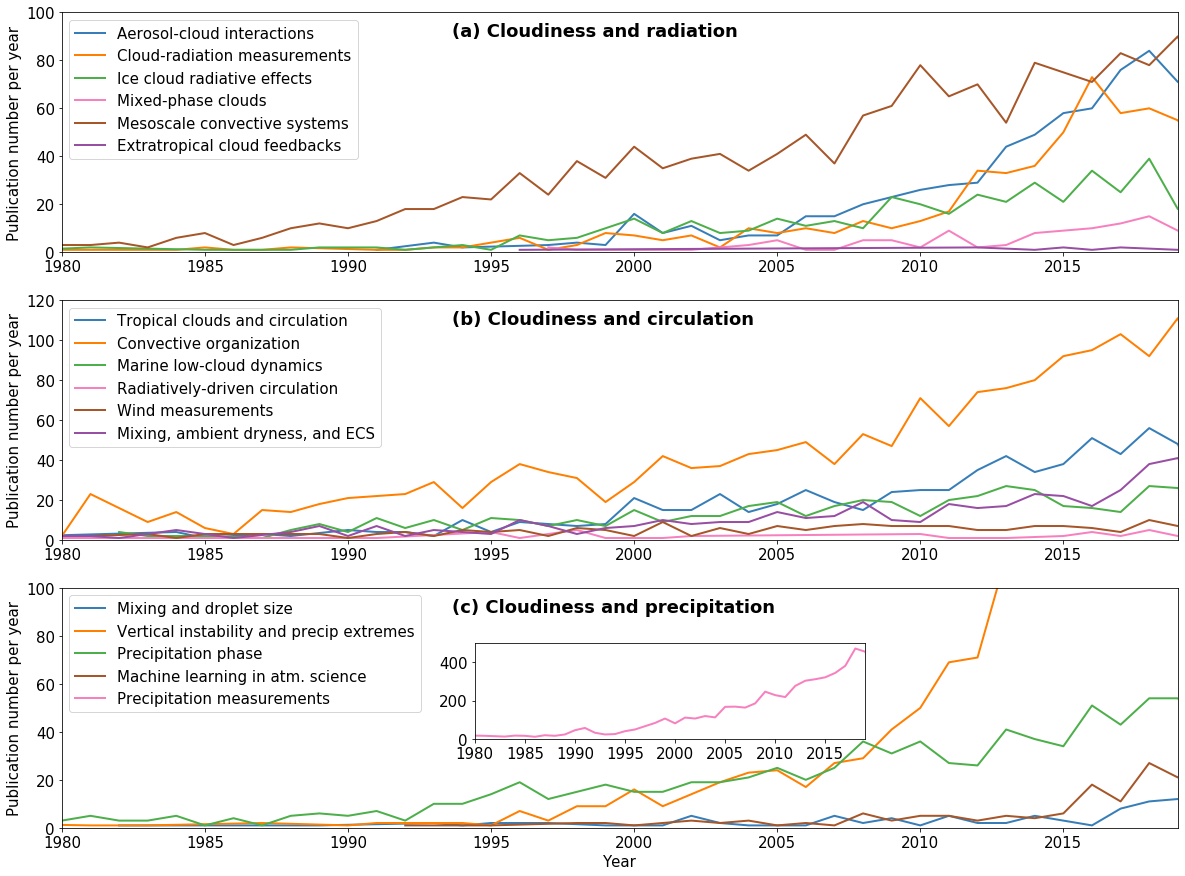

In [13]:
# Plot the publications per year over time for the three themes.
fs = 15
# Colorblind cycle from https://gist.github.com/thriveth/8560036
CB_farbe = ['#377eb8','#ff7f00','#4daf4a','#f781bf','#a65628','#984ea3',
            '#999999','#e41a1c','#dede00']
lbl = ['Aerosol-cloud interactions','Cloud-radiation measurements','Ice cloud radiative effects',\
      'Mixed-phase clouds','Mesoscale convective systems','Extratropical cloud feedbacks',\
      'Tropical clouds and circulation','Convective organization','Marine low-cloud dynamics',\
      'Radiatively-driven circulation','Wind measurements','Mixing, ambient dryness, and ECS',\
      'Mixing and droplet size','Vertical instability and precip extremes','Precipitation phase',\
      'Precipitation measurements','Machine learning in atm. science']
fig3, ax = plt.subplots(nrows=3,ncols=1,figsize=(20,15))
for i in np.arange(2,8):
    temp = title_per_yr.loc[[float(i)]]
    ax[0].plot(temp.index.get_level_values('Year'),temp['Title'],color=CB_farbe[i-2],label=lbl[i-2],linewidth=2)
    
ax[0].set_ylim([0,100])
ax[0].set_xlim([1980,2019])
ax[0].legend(loc='upper left',fontsize=fs)
ax[0].tick_params(axis='both',labelsize=fs)
ax[0].text(0.35,0.9,'(a) Cloudiness and radiation',weight='bold',fontsize=fs+3,transform=ax[0].transAxes)
ax[0].set_ylabel('Publication number per year',fontsize=fs)

for i in np.arange(8,14):
    temp = title_per_yr.loc[[float(i)]]
    ax[1].plot(temp.index.get_level_values('Year'),temp['Title'],color=CB_farbe[i-8],label=lbl[i-2],linewidth=2)
    
ax[1].set_ylim([0,120])
ax[1].set_xlim([1980,2019])
ax[1].legend(loc='upper left',fontsize=fs)
ax[1].tick_params(axis='both',labelsize=fs)
ax[1].text(0.35,0.9,'(b) Cloudiness and circulation',weight='bold',fontsize=fs+3,transform=ax[1].transAxes)
ax[1].set_ylabel('Publication number per year',fontsize=fs)

lns = []
for i in [14,15,16,18]:
    temp = title_per_yr.loc[[float(i)]]
    lns = lns + ax[2].plot(temp.index.get_level_values('Year'),temp['Title'],color=CB_farbe[i-14],label=lbl[i-2],linewidth=2)
subax1 = add_subplot_axes(ax[2],[0.37,0.37,0.35,0.4])   
temp = title_per_yr.loc[[float(17)]]
lns = lns + subax1.plot(temp.index.get_level_values('Year'),temp['Title'],color=CB_farbe[3],label=lbl[15],linewidth=2)
subax1.set_xlim([1980,2019])
subax1.set_ylim([0,500])
subax1.tick_params(axis='both',labelsize=fs)
labs = [l.get_label() for l in lns]

ax[2].set_ylim([0,100])
ax[2].set_xlim([1980,2019])
ax[2].legend(lns,labs,loc=0,fontsize=fs)
ax[2].tick_params(axis='both',labelsize=fs)
ax[2].text(0.35,0.9,'(c) Cloudiness and precipitation',weight='bold',fontsize=fs+3,transform=ax[2].transAxes)
ax[2].set_ylabel('Publication number per year',fontsize=fs)
ax[2].set_xlabel('Year',fontsize=fs)

#fig3.savefig('publications-by-chapter.pdf')

## Fig 4: Word clouds by topic - clouds, circulation, radiation, precipitation

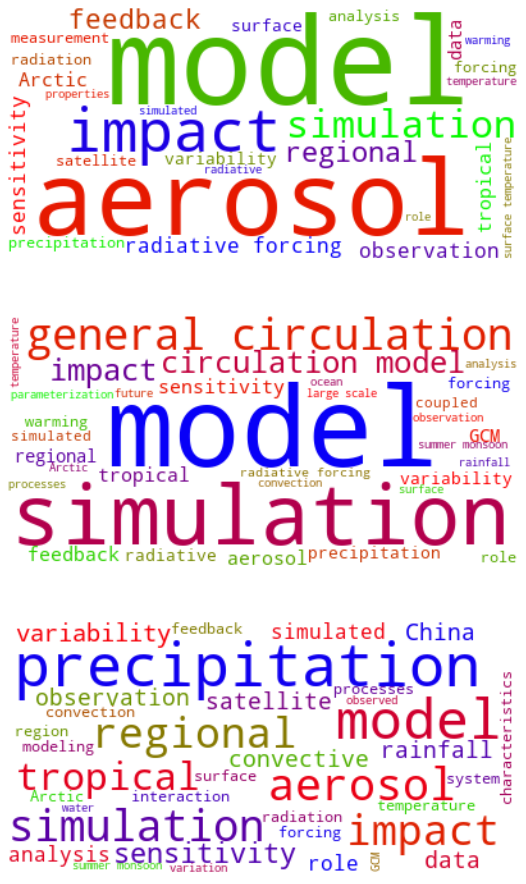

In [12]:
fig4,ax = plt.subplots(nrows=3,ncols=1,figsize=(12,16))

text = open('cloud_circulation_title.txt').read()
woerter = ['cloud','clouds','climate','using','change','Comparison','Evaluation','effect','global','study','effects',\
          'atmospheric','changes','response','based','Part','characteristic','influence']
nuage1 = wordcloud.WordCloud(background_color='white',max_words=50,colormap=cm.brg,
                             stopwords=list(wordcloud.STOPWORDS)+woerter,
                             min_font_size=8).generate(text)
text = open('cloud_radiation_title.txt').read()
nuage2 = wordcloud.WordCloud(background_color='white',max_words=70,colormap=cm.brg,
                             stopwords=list(wordcloud.STOPWORDS)+woerter,
                             min_font_size=8).generate(text)
text = open('cloud_precipitation_title.txt').read()
nuage3 = wordcloud.WordCloud(background_color='white',max_words=70,colormap=cm.brg,
                             stopwords=list(wordcloud.STOPWORDS)+woerter,
                             min_font_size=8).generate(text)

ax[0].imshow(nuage2, interpolation='bilinear')
ax[0].axis('off')
ax[1].imshow(nuage1, interpolation='bilinear')
ax[1].axis('off')
ax[2].imshow(nuage3, interpolation='bilinear')
ax[2].axis('off')
plt.tight_layout
fig4.savefig('title-word-cloud.pdf',dpi=300,bbox_inches='tight')

# Fig 5: Author networks by theme

In [13]:
# Import some new packages to build a network.
from collections import Counter
from itertools import combinations
import networkx as nx
from nxviz.plots import CircosPlot
from random import sample
from matplotlib import pylab

In [14]:
# Extract author connections. Taking from the following:
# https://towardsdatascience.com/network-analysis-to-quickly-get-insight-into-an-academic-field-with-python-cd891717d547
def author_graph(fi,yr1,yr2):
    scopus = pd.read_csv(fi)
    scopus = scopus[(scopus.Year > yr1) & (scopus.Year <= yr2)]
    authors = scopus['Author(s) ID']
    #authors_flat = [b.strip() for a in list(authors) for b in a.split(';')]

    # Create all 2/pair combinations of authors from dataframe field above.
    author_connections = list(
        map(lambda x: list(combinations(x.split(';'),2)), authors))
    # Remove empty strings in the list.
    author_connections = [list(filter(lambda t: '' not in t, l2)) for l2 in author_connections]
    flat_connections = [item for sublist in author_connections for item in sublist]

    # Create a dataframe from the connections above.
    connx = pd.DataFrame(flat_connections,columns=['From','To'])
    connx_graph = connx.groupby(["From", "To"]).size().reset_index()
    connx_graph.columns = ["From", "To", "Count"]

    # Create a graph from the connections dataframe. 
    G = nx.from_pandas_edgelist(connx_graph, source="From", target="To", edge_attr="Count")
    print('Number of nodes: ' + str(G.number_of_nodes()) + ', Number of edges: ' + str(G.number_of_edges()))
    return G

In [15]:
# Function to visualize a large graph without memory error.
# Taken from https://stackoverflow.com/questions/17381006/
# Kamada-Kawai path-length cost-function or Fruchterman-Reingold layout (spring)
# F-R is force-directed graph drawing, seeking to "position the nodes in 2D space 
# so that all edges are of equal length with as few crossing edges as possible."
def save_graph(graphs,file_name,nc):
    # initialize Figure
    c = int(np.ceil(len(graphs)/nc))
    letra = ['(' + a + ')' for a in string.ascii_lowercase[:len(graphs)]]
    fig, axes = plt.subplots(nrows=c, ncols=nc, figsize=(15,20),dpi=300)
    for ax, g, let in zip(axes.flatten(), graphs, letra):
        pos = nx.circle_layout(g)
        d = dict(g.degree)
        nx.draw_networkx_nodes(g,pos,nodelist=d.keys(),node_size=[v*50 for v in d.values()],
                           node_color=[v for v in d.values()],alpha=0.5,ax=ax,cmap=cm.jet,linewidths=1)
        nx.draw_networkx_edges(g,pos,ax=ax)
        ax.text(0.05,0.93,let,weight='bold',fontsize=15,transform=ax.transAxes)
        ax.axis('off')
    
    plt.savefig(file_name,bbox_inches='tight')
    pylab.close()
    del fig

In [ ]:
# Use the two functions above to generate network plots for each theme and different time periods
G1 = author_graph('clouds-climate-radiation.csv',1988,1989)
G2 = author_graph('clouds-climate-radiation.csv',1998,1999)
G3 = author_graph('clouds-climate-circulation.csv',1988,1989)
G4 = author_graph('clouds-climate-circulation.csv',1998,1999)
G5 = author_graph('clouds-climate-precipitation.csv',1988,1989)
G6 = author_graph('clouds-climate-precipitation.csv',1998,1999)
#save_graph([G1,G2,G3,G4,G5,G6],'author-network-by-theme.pdf',2)

print(nx.info(G1))
print(nx.info(G2))
print(nx.info(G3))
print(nx.info(G4))
print(nx.density(G1),nx.density(G2))
print(nx.density(G3),nx.density(G4))
print(nx.density(G5),nx.density(G6))
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

In [41]:
print('NETWORK INFO AND DENSITY FOR 2019 BY THEME')
G1 = author_graph('clouds-climate-radiation.csv',2018,2019)
G2 = author_graph('clouds-climate-circulation.csv',2018,2019)
G3 = author_graph('clouds-climate-precipitation.csv',2018,2019)

print(nx.info(G1))
print(nx.density(G1))
# Return the list of components and extract the largest.
comp = nx.connected_components(G1)
G1_sub = G1.subgraph(max(comp,key=len))
print(nx.diameter(G1_sub))
print(comp)
#print(max(comp,key=len))
#print(nx.info(G2))
#print(nx.density(G2))
#print(nx.info(G3))
#print(nx.density(G3))
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

#print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

NETWORK INFO AND DENSITY FOR 2019 BY THEME
Number of nodes: 1929, Number of edges: 11265
Number of nodes: 750, Number of edges: 3798
Number of nodes: 1269, Number of edges: 5025
Name: 
Type: Graph
Number of nodes: 1929
Number of edges: 11265
Average degree:  11.6796
0.006057897691707052
12
<generator object connected_components at 0x2b905f972fc0>
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


# Fig 6: Author networks by chapter

In [168]:
# Function to visualize a large graph without memory error. Same as above but different layout
def save_graph2(graphs,file_name,nc):
    # initialize Figure
    c = int(np.ceil(len(graphs)/nc))
    letra = ['(' + a + ')' for a in string.ascii_lowercase[:len(graphs)]]
    fig, axes = plt.subplots(nrows=c, ncols=nc, figsize=(15,20),dpi=300)
    for ax, g, let in zip(axes.flatten(), graphs, letra):
        pos = nx.spring_layout(g)
        d = dict(g.degree)
        nx.draw_networkx_nodes(g,pos,nodelist=d.keys(),node_size=[v*50 for v in d.values()],
                           node_color=[v for v in d.values()],alpha=0.5,ax=ax,cmap=cm.jet,linewidths=1)
        nx.draw_networkx_edges(g,pos,ax=ax)
        ax.text(0.05,0.93,let,weight='bold',fontsize=15,transform=ax.transAxes)
        ax.set_yticks([])
        ax.set_xticks([])
    
    plt.savefig(file_name,bbox_inches='tight')
    pylab.close()
    del fig

In [171]:
G_list = []
for chapter in [2,8,15,3,10,16,4,13,18]:#np.arange(2,19):
    G = author_graph('chapter' + str(chapter) + '-scopus.csv',2015,2016)
    G_list.append(G)
    
save_graph2(G_list,'author-network-by-chapter.pdf',3)

Number of nodes: 316, Number of edges: 1474
Number of nodes: 196, Number of edges: 702
Number of nodes: 629, Number of edges: 1789
Number of nodes: 262, Number of edges: 741
Number of nodes: 71, Number of edges: 209
Number of nodes: 174, Number of edges: 428
Number of nodes: 161, Number of edges: 513
Number of nodes: 70, Number of edges: 129
Number of nodes: 76, Number of edges: 169


/pf/b/b380873/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


# Fig 7: Pie chart of techniques

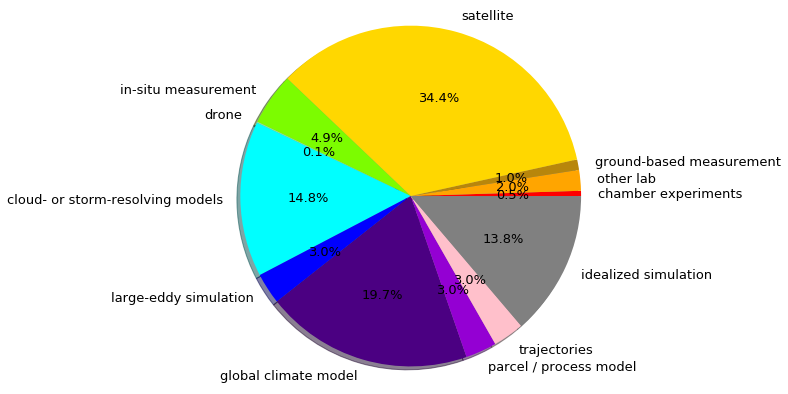

In [34]:
fs = 13
techniques = ['chamber experiments','other lab','ground-based measurement','satellite','in-situ measurement',\
             'drone','cloud- or storm-resolving models','large-eddy simulation','global climate model',\
             'parcel / process model','trajectories','idealized simulation']
data = [0.5,2,1,35,5,0.1,15,3,20,3,3,14]
farbe = ['red','orange','darkgoldenrod','gold','lawngreen','lightgreen','aqua','blue','indigo','darkviolet',\
        'pink','gray']
fig7 = plt.figure(figsize=(10,7))
p, txt, atxt = plt.pie(data,labels=techniques,autopct='%1.1f%%',shadow=True,colors=farbe);
plt.gca().axis('equal');
[ _.set_fontsize(fs) for _ in txt];
[ _.set_fontsize(fs) for _ in atxt];
fig7.savefig('dist-of-techniques.pdf',bbox_inches='tight')

In [ ]:
# SCOPUS DATAFRAME
ch4_scopus = pd.read_csv('ch4_scopus.csv')
# Remove the 'Source' column since we know the data here is from Scopus.
ch4_scopus.drop(columns=['Source'], axis=1, inplace=True)
#ch4_scopus.head()
print(ch4_scopus.columns)
print(ch4_scopus.shape)

# WEB OF SCIENCE DATAFRAME
ch4_webofsci = pd.read_excel('ch4_webofscience.xls')
# Select the fields which are also in the Scopus dataframe.
ch4_webofsci = ch4_webofsci[['Publication Type', 'Authors', 'Book Authors', 'Article Title', 'Source Title', 
              'Publication Year', 'Times Cited, All Databases', 'Document Type', 'Conference Title', 'Publisher','DOI',
              'Open Access Designations']]
print(ch4_webofsci.columns)
print(ch4_webofsci.shape)

# SPRINGERLINK DATAFRAME
ch4_springer = pd.read_csv('ch4_springerlink.csv')
print(ch4_springer.columns)

# PNAS

# COPERNICUS